In [2]:
import numpy as np
from torchvision.datasets import MNIST


def download_mnist(is_train: bool):
    dataset = MNIST(
        root="./data",
        transform=lambda x: np.array(x).flatten(),
        download=True,
        train=is_train,
    )

    mnist_data = []
    mnist_labels = []

    for image, label in dataset:
        mnist_data.append(image)
        mnist_labels.append([int(i == label) for i in range(10)])

    return mnist_data, mnist_labels


train_X, train_Y = download_mnist(True)
test_X, test_Y = download_mnist(False)

# normalize data
train_X, train_Y = np.divide(np.array(train_X), 255), np.array(train_Y)
test_X, test_Y = np.divide(np.array(test_X), 255), np.array(test_Y)

In [25]:
import sys
import matplotlib.pyplot as plt


np.set_printoptions(threshold=sys.maxsize)


class Layer:
    def forward(self, y, testing=False):
        """Y is the layer before the current one (from left-to-right)."""
        pass

    def backward(self, dy, learn_rate, momentum=0.0, regularization_factor=0.0):
        """Backward propagate the current layer.

        Params are the dy of the layer after this one and the learning rate."""
        pass

    def get_shape(self):
        pass

    def set_input_size(self, input_size: int | None = None):
        pass


def cross_entropy(prob, target):
    return -np.sum(target * np.log2(prob, where=prob > 0))


class Network:
    def __init__(self, verbose=False):
        self.layers: list[Layer] = []
        self.verbose = verbose

    def add(self, layer: Layer):
        if len(self.layers) > 0:
            layer.set_input_size(self.layers[-1].get_shape()[1])
        self.layers.append(layer)

    def summary(self):
        for layer in self.layers:
            print(layer.get_shape())

    def __train(self, x, t, learn_rate, momentum, regularization_factor):
        # forward propagation
        y = x.T  # the outputs of all the layers
        w = 0

        for layer in self.layers:
            y = layer.forward(y)

            # compose sum(weight^2) for loss
            if isinstance(layer, Dense):
                w += np.sum(np.power(layer.weights, 2))

        w = 0.5 * regularization_factor * w

        # get average loss for batch
        losses = np.array([cross_entropy(yi, ti) for ti, yi in zip(t, y.T)])
        loss = np.average(losses) + w

        # backward propagation
        dy = y - t.T  # gradient of cross entropy + softmax

        for layer in reversed(self.layers):
            dy = layer.backward(dy, learn_rate, momentum, regularization_factor)

        return loss

    def train(
        self,
        train_x,
        train_t,
        learn_rate=1,
        epochs=1,
        batch_size=1,
        momentum=0.0,
        regularization_factor=0.0,
        test_x=None,
        test_t=None,
    ):
        losses = []
        accuracies = []
        test_accuracies = []
        splits = len(train_x) // batch_size

        for epoch in range(epochs):
            loss = 0

            # shuffle data
            perm = np.random.permutation(len(train_x))
            train_x, train_t = train_x[perm], train_t[perm]

            # train for each batch
            for batch_input, batch_labels in zip(
                np.array_split(train_x, splits), np.array_split(train_t, splits)
            ):
                loss += self.__train(batch_input, batch_labels, learn_rate, momentum, regularization_factor / len(train_x))

            # get average loss for whole train data
            loss = loss / splits
            losses.append(loss)

            # get model accuracy at current epoch on training data
            train_acc = self.test(train_x, train_t)
            accuracies.append(train_acc)

            if self.verbose:
                print(f"{epoch=:4}, ", end="")
                print(f"{train_acc=:.2f}, ", end="")
                print(f"{loss=:.2f}, ", end="")

            # get model accuracy at current epoch on test data
            if test_x is not None and test_t is not None:
                test_acc = self.test(test_x, test_t)
                test_accuracies.append(test_acc)

                if self.verbose:
                    print(f"{test_acc=:.2f}")

        # plot average losses, train accuracies and test accuracies
        plt.title("train accuracy (blue) vs test accuracy (green)")
        plt.plot(accuracies, ".-b")

        if test_x is not None and test_t is not None:
            plt.plot(test_accuracies, ".-g")

        plt.show()

        plt.title("loss")
        plt.plot(losses, ".-r")
        plt.show()

    def test(self, x, t):
        # forward propagation
        y = x.T

        for layer in self.layers:
            y = layer.forward(y, testing=True)

        return np.sum(np.argmax(y, axis=0) == np.argmax(t.T, axis=0)) / len(x)


def softmax(weighted_sum):
    powed = np.exp(weighted_sum - np.max(weighted_sum))
    return np.divide(powed, powed.sum())


def relu(weighted_sum):
    return np.maximum(0, weighted_sum)


class Dense(Layer):
    def __init__(self, perceptrons, activation, input_size: int | None = None):
        """Softmax activation should be used only if the layer is the last one in the network, otherwise things will break."""
        self.state = None  # used for memorizing input data of forward in order to use it on backward
        self.old_deltas = (0.0, 0.0) # used for momentum
        self.biases = None
        self.weights = None
        self.perceptrons = perceptrons
        self.input_size = None
        self.activation = activation
        if input_size:
            self.set_input_size(input_size)

    def get_shape(self):
        return self.weights.shape[::-1]  # (input size, output size)

    def set_input_size(self, input_size: int | None = None):
        self.input_size = input_size
        # init weights and biases
        self.weights = np.random.normal(
            scale=np.sqrt(1 / input_size), size=(self.perceptrons, input_size)
        )
        self.biases = np.zeros((self.perceptrons, 1))

    def forward(self, y, testing=False):
        y_tilde = self.weights @ y + self.biases

        # remember y of previous layer and unactivated y of current layer for backward propagation step
        self.state = (y.copy(), y_tilde)

        # apply activation on each row of the weighted sums
        return np.apply_along_axis(self.activation, axis=0, arr=y_tilde)

    def backward(self, dy, learn_rate, momentum=0.0, regularization_factor=0.0):
        # recall the y of previous layer and unactivated y of current layer
        y_prev, y_tilde = self.state
        dy_tilde = dy.copy()

        if self.activation == softmax:
            # since we assumed that the softmax is used only if this is the last layer, dy shouldn't be modified
            pass
        elif self.activation == relu:
            dy_tilde[y_tilde < 0] = 0

        # compute gradients for weights and biases
        old_dw, old_db = self.old_deltas

        n = dy_tilde.shape[1]
        dw = momentum * old_dw + learn_rate * dy_tilde @ y_prev.T
        db = momentum * old_db + learn_rate * dy_tilde.sum(axis=1).reshape(-1, 1)

        # compute gradient of previous layer in the chain
        dy_prev = self.weights.T @ dy_tilde

        # update current layer weights and biases
        # apply weight decay
        self.weights = (1 - learn_rate * regularization_factor) * self.weights - dw
        self.biases -= db

        self.old_deltas = dw, db

        return dy_prev


class Dropout(Layer):
    def __init__(self, drop_rate, input_size: int | None = None):
        self.biases = None
        self.weights = None
        self.keep_rate = 1 - drop_rate
        self.input_size = None
        if input_size:
            self.set_input_size(input_size)

    def get_shape(self):
        return (self.input_size, self.input_size)  # (input size, output size)

    def set_input_size(self, input_size: int | None = None):
        self.input_size = input_size

    def forward(self, y, testing=False):
        # deactivate dropout on testing
        if testing:
            return y

        # create dropout mask for the column vectors y
        mask = (np.random.uniform(size=y.shape) < self.keep_rate) / self.keep_rate
        return y * mask

    def backward(self, dy, learn_rate, momentum=0.0):
        # do nothing at this step
        return dy

(784, 100)
(100, 10)


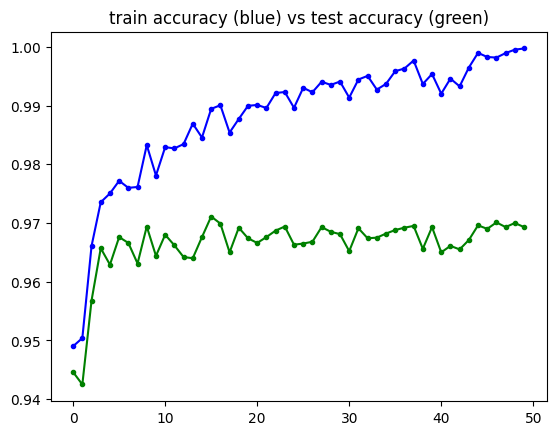

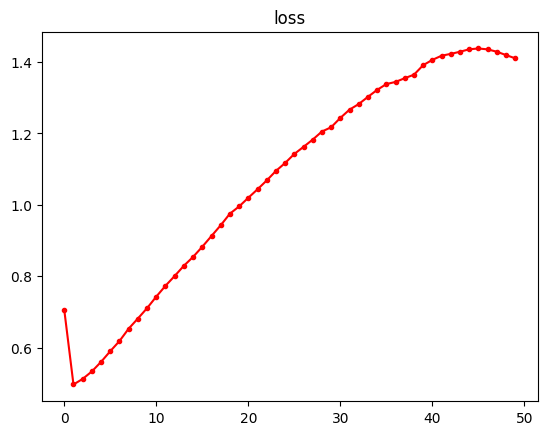

acc=0.9693


In [ ]:
network = Network()

# network.add(Dense(10, activation=softmax, input_size=784))

network.add(Dense(100, activation=relu, input_size=784))
# network.add(Dropout(0.1))
network.add(Dense(10, activation=softmax))

network.summary()

network.train(
    train_X,
    train_Y,
    learn_rate=0.01,
    epochs=50,
    batch_size=100,
    # momentum=0.2,
    # regularization_factor=60.0,
    test_x=test_X,
    test_t=test_Y,
)

print(f"acc={network.test(test_X, test_Y)}")

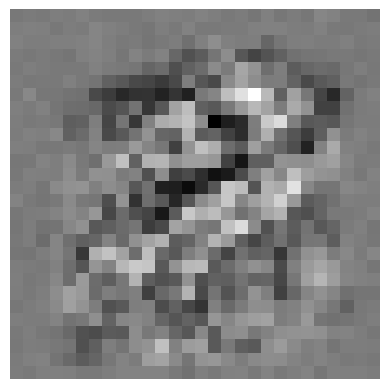

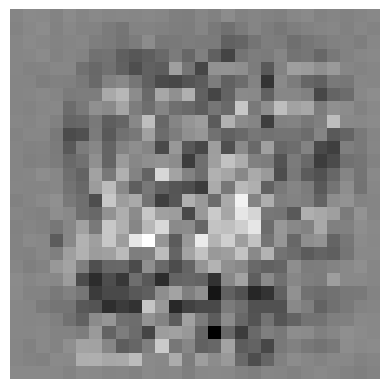

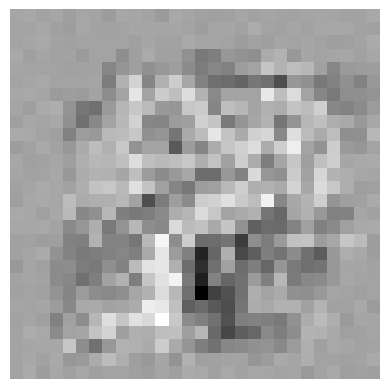

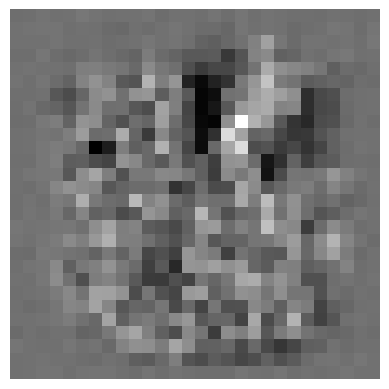

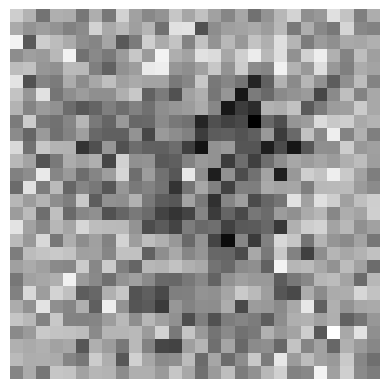

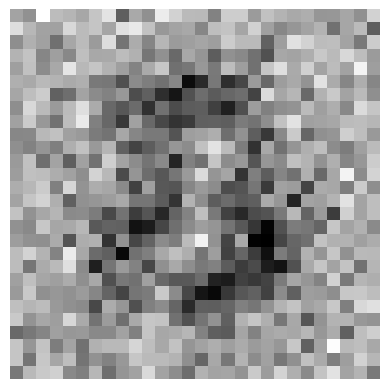

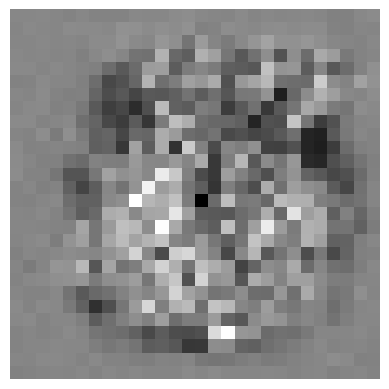

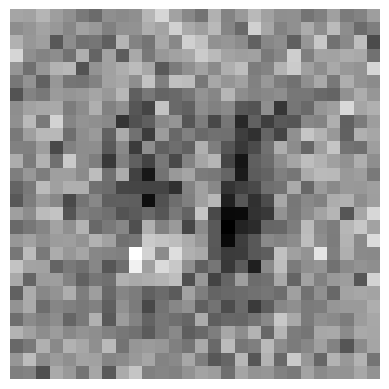

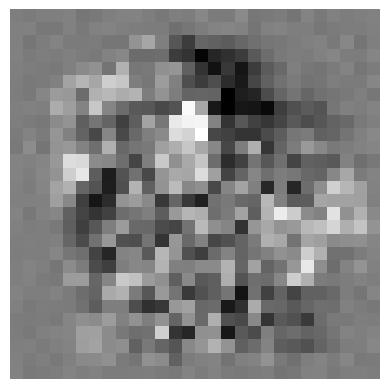

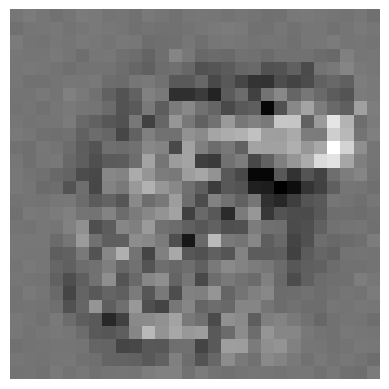

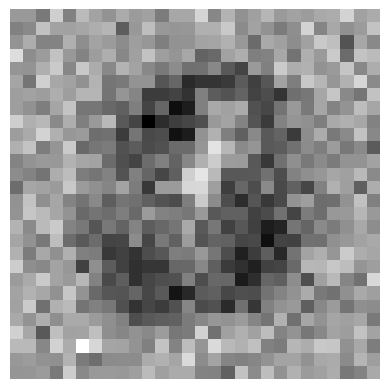

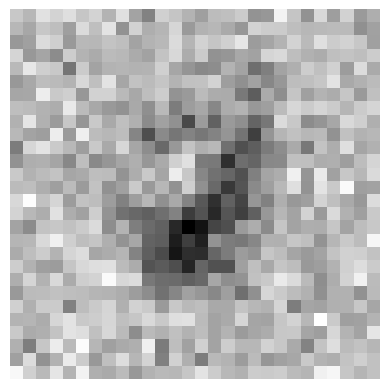

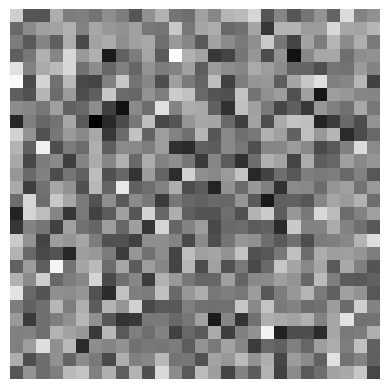

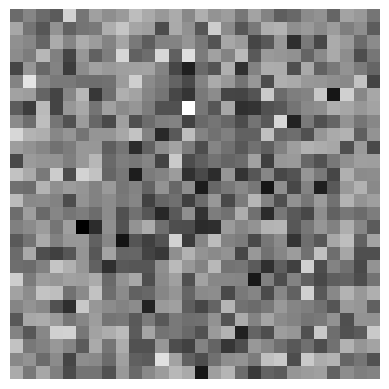

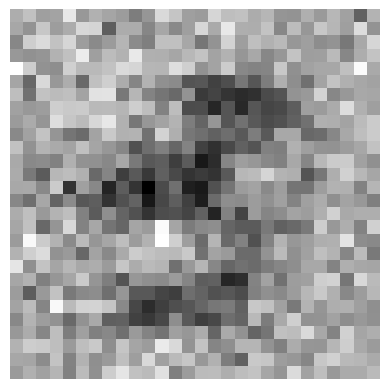

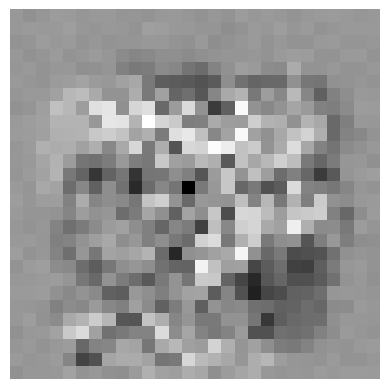

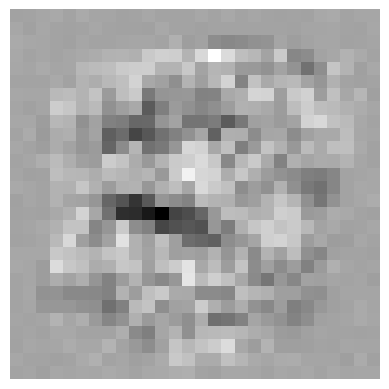

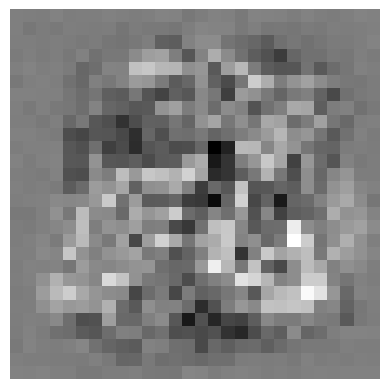

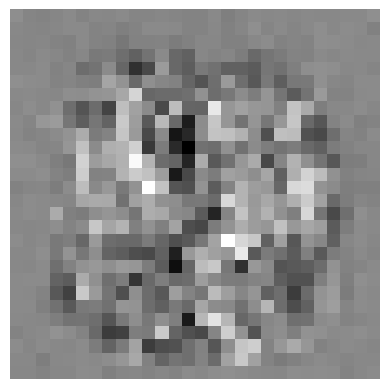

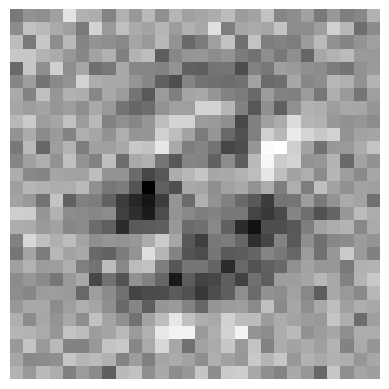

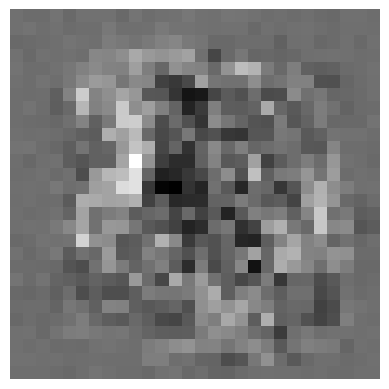

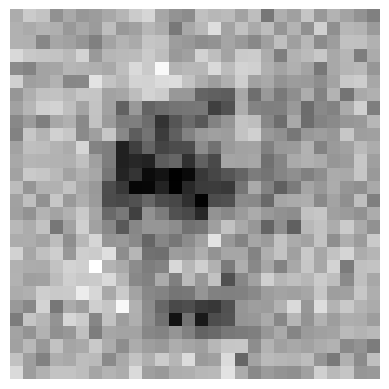

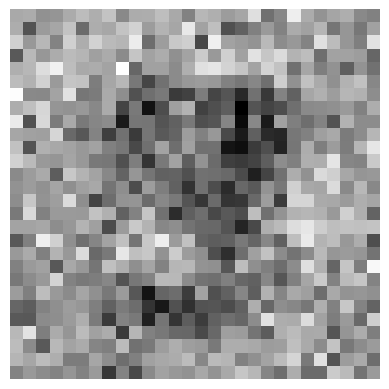

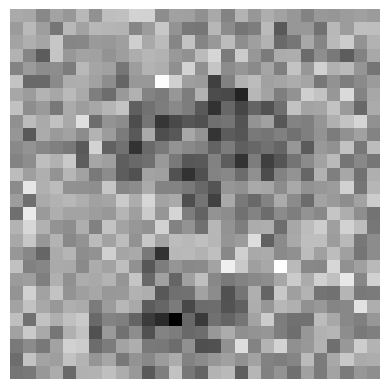

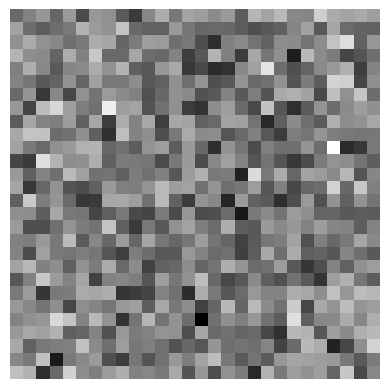

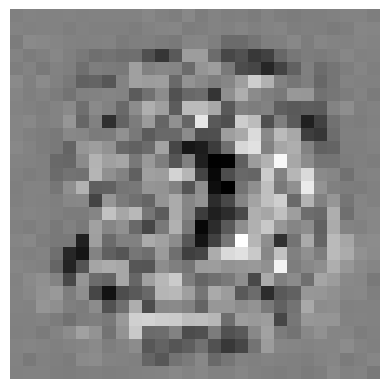

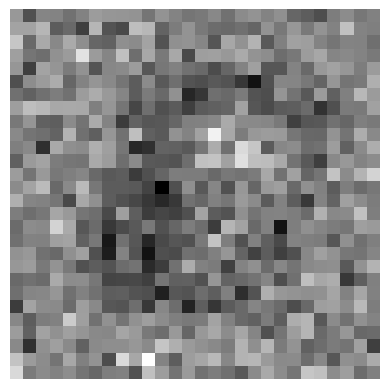

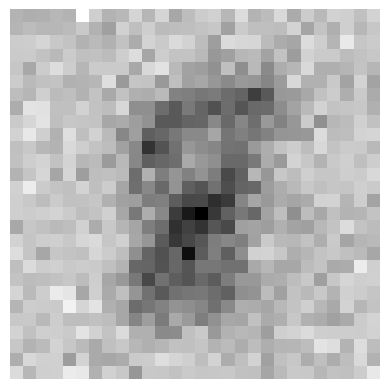

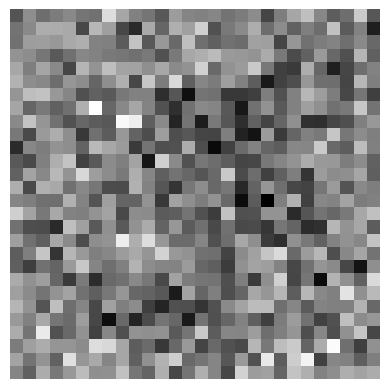

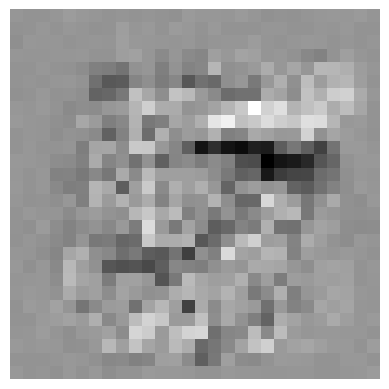

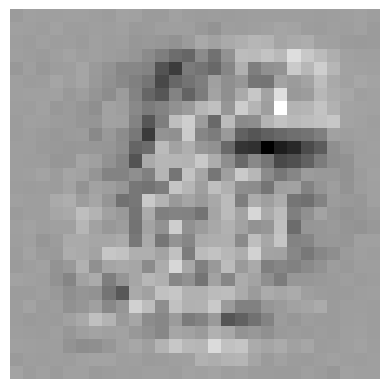

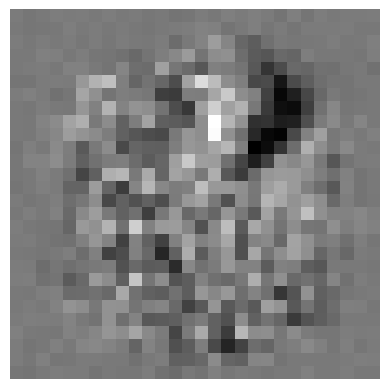

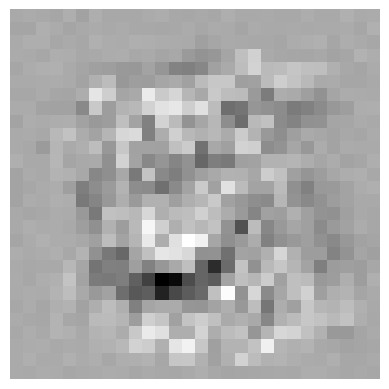

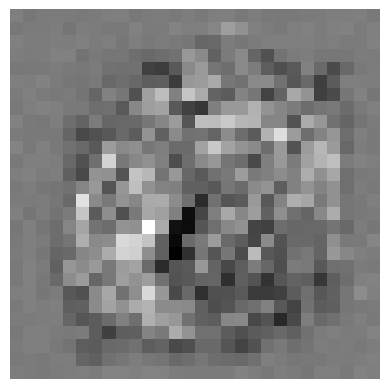

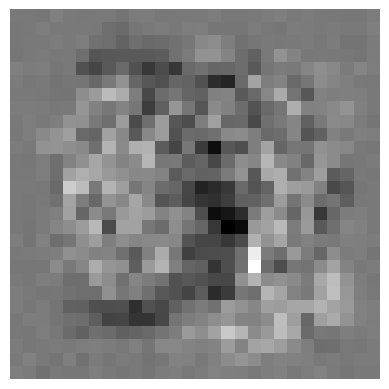

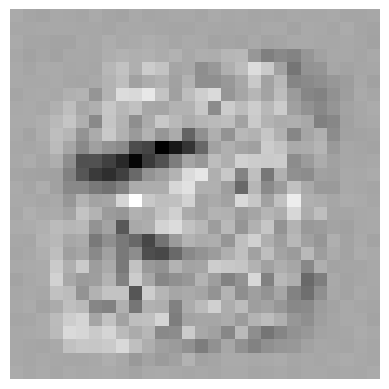

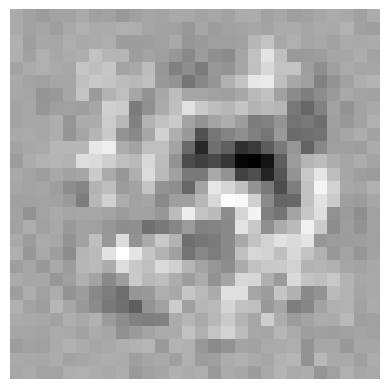

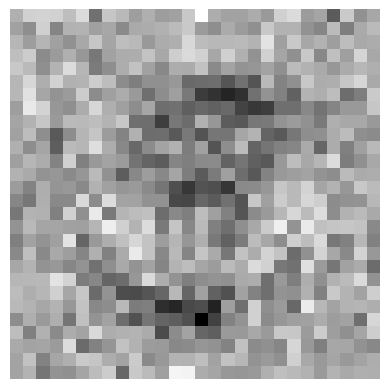

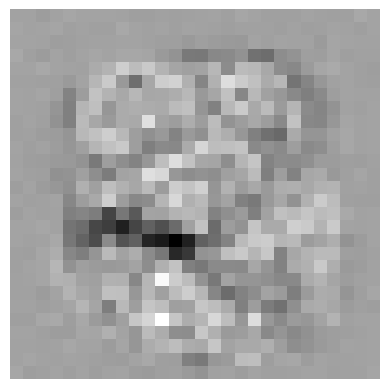

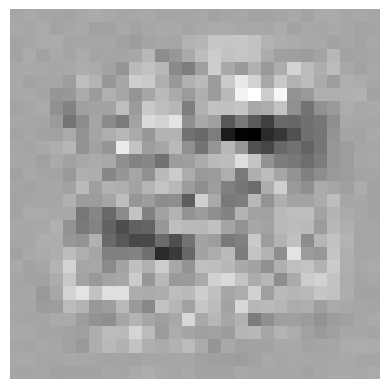

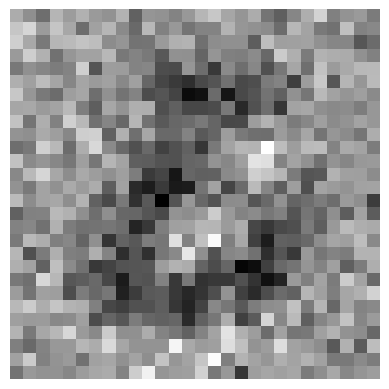

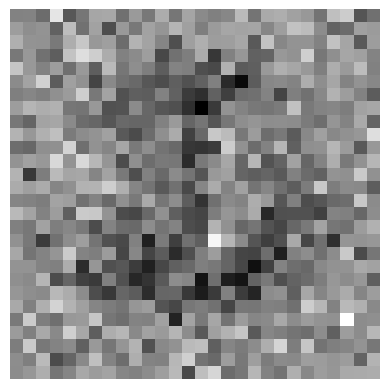

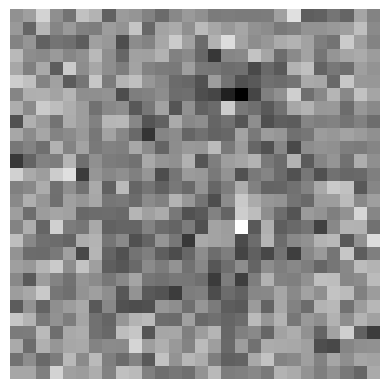

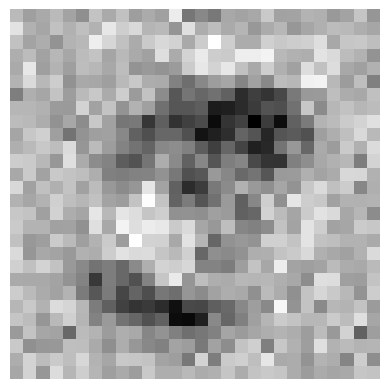

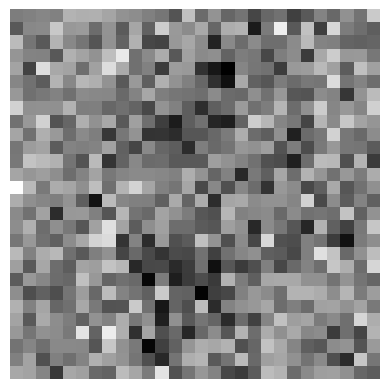

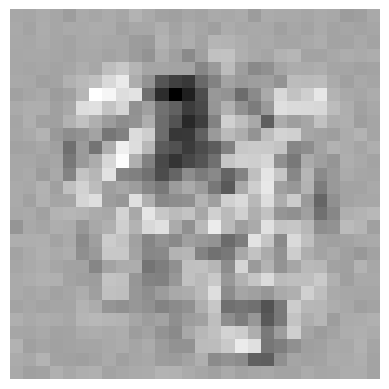

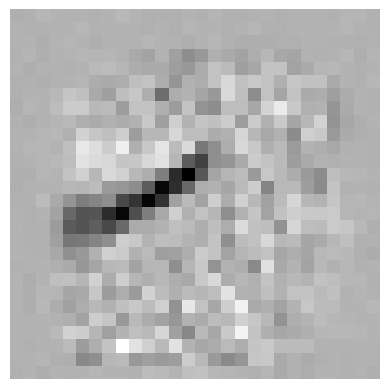

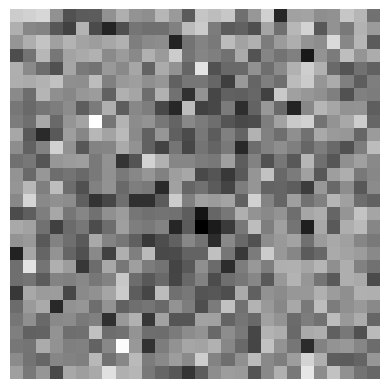

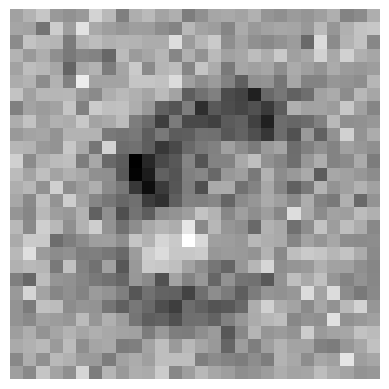

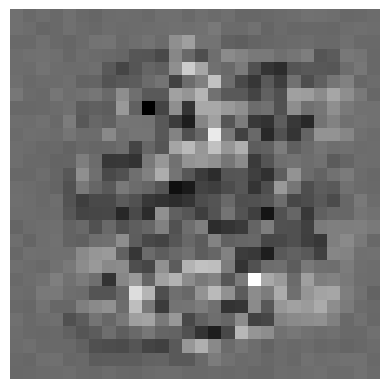

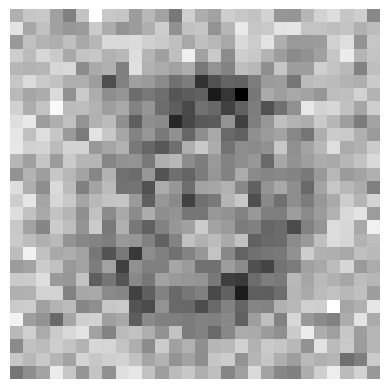

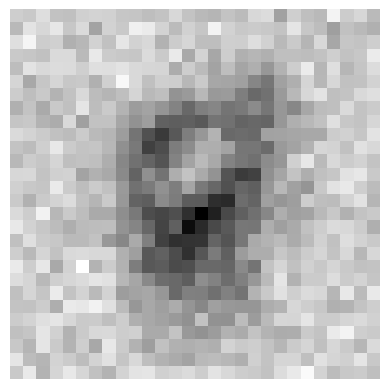

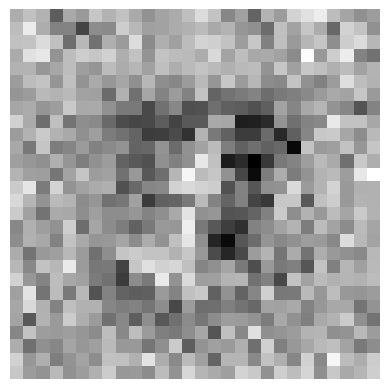

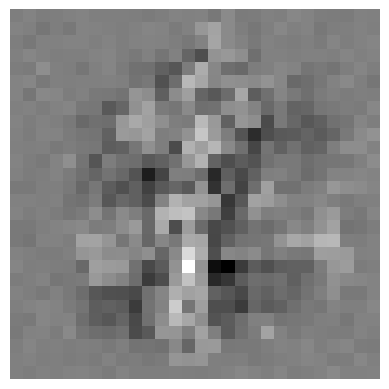

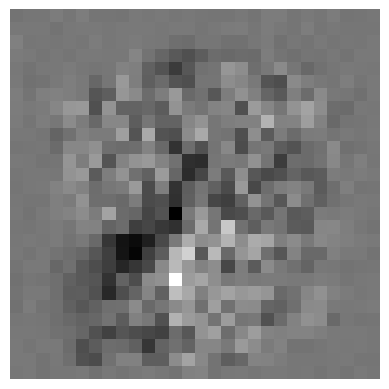

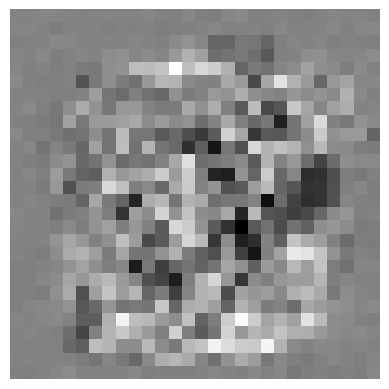

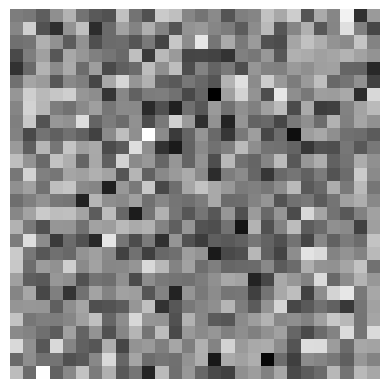

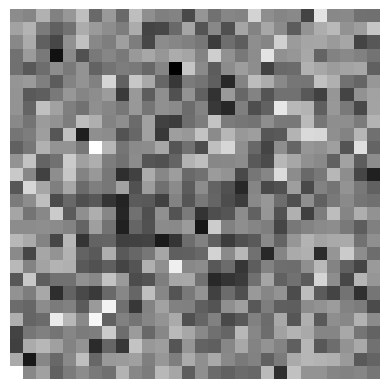

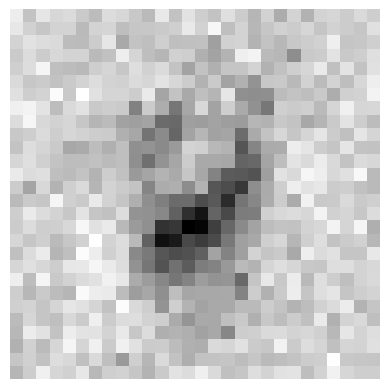

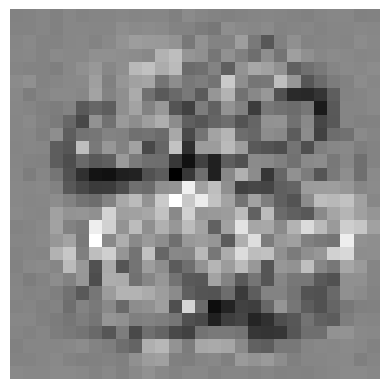

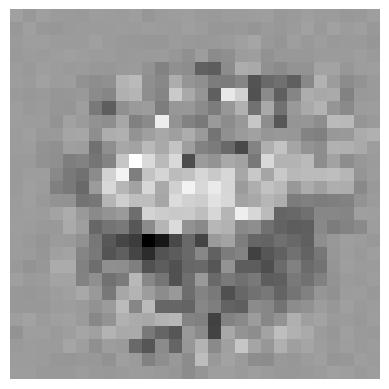

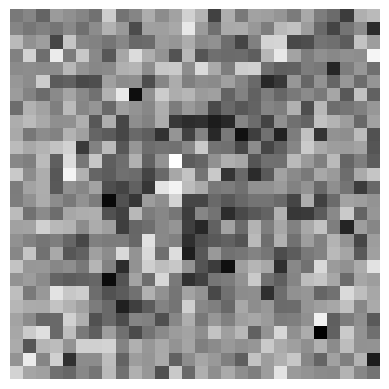

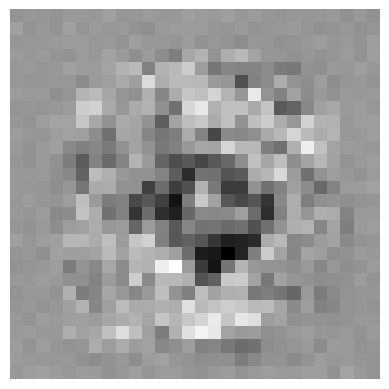

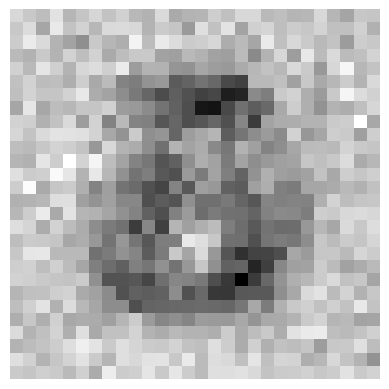

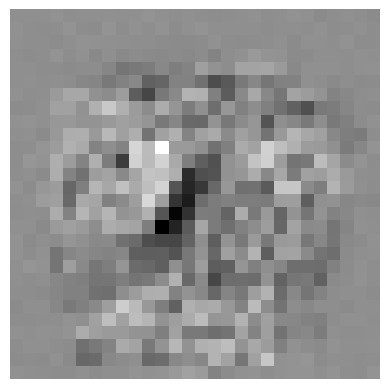

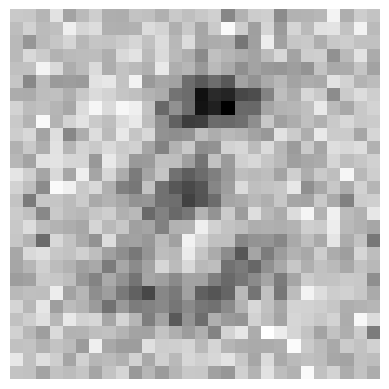

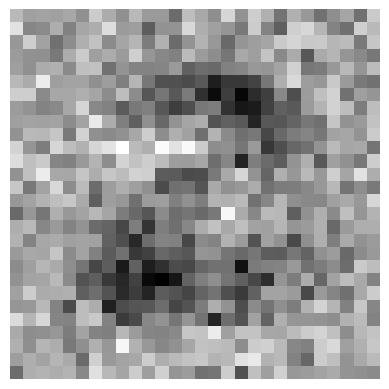

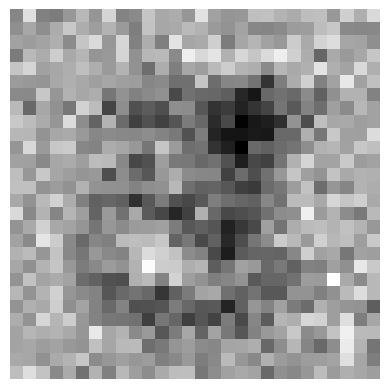

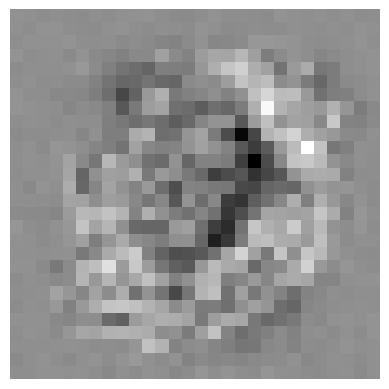

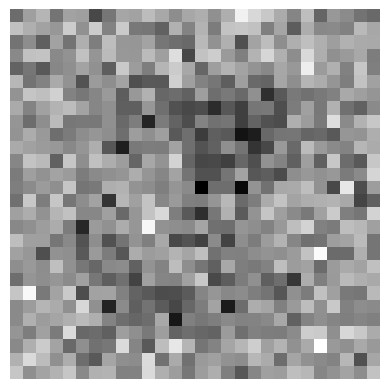

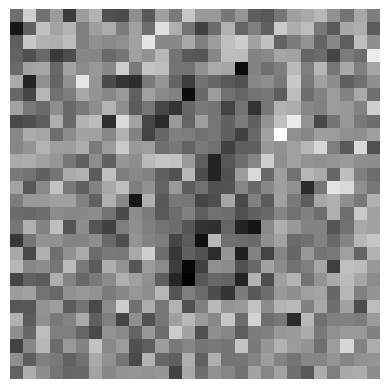

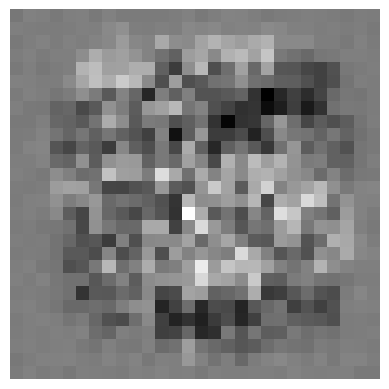

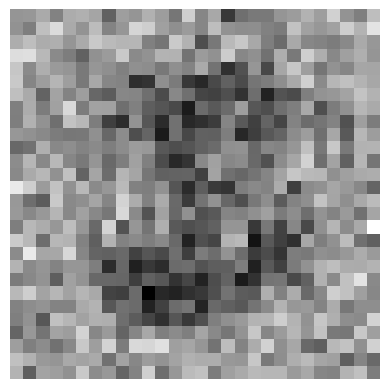

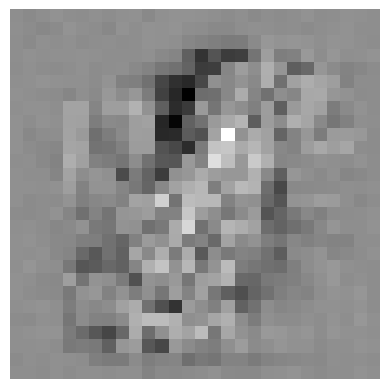

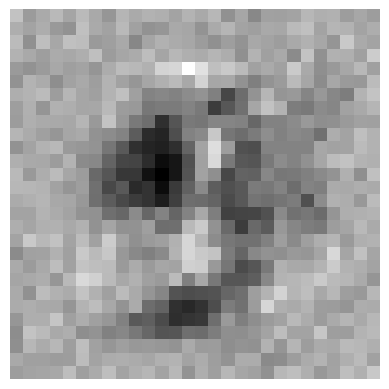

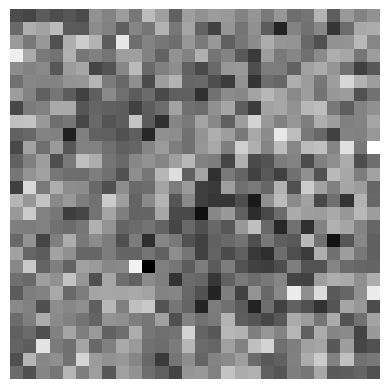

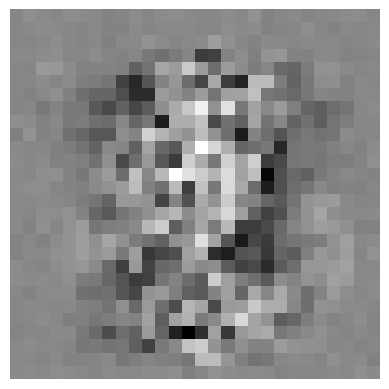

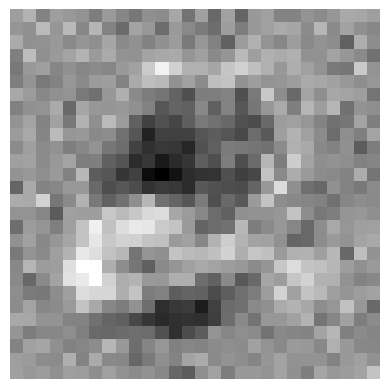

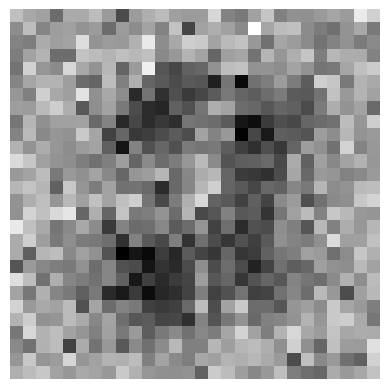

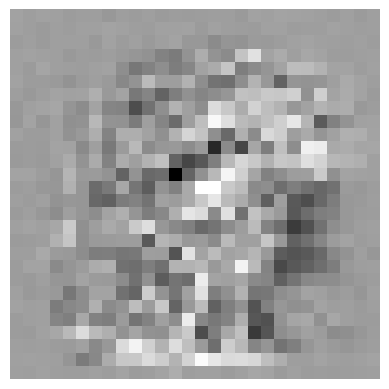

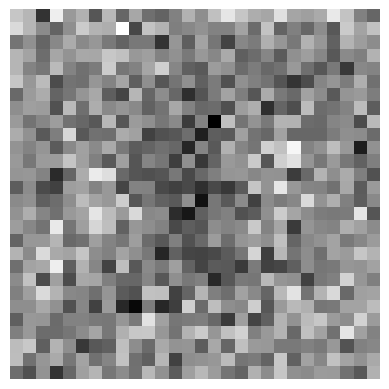

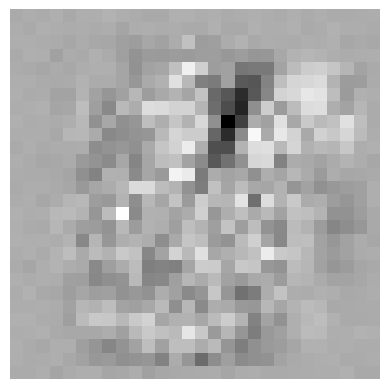

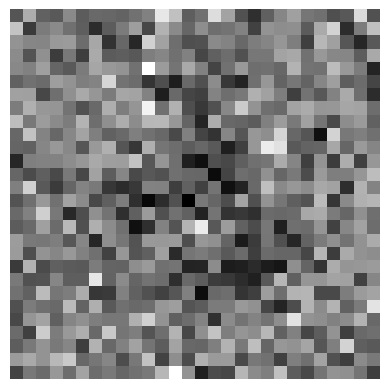

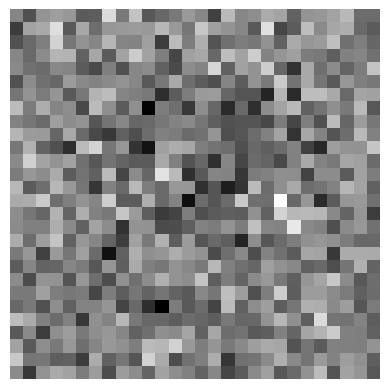

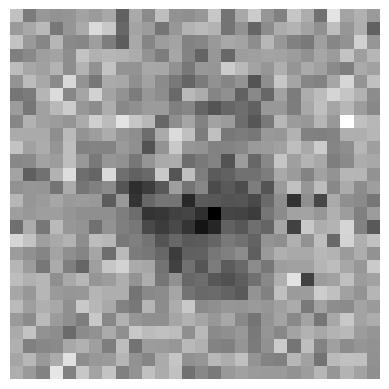

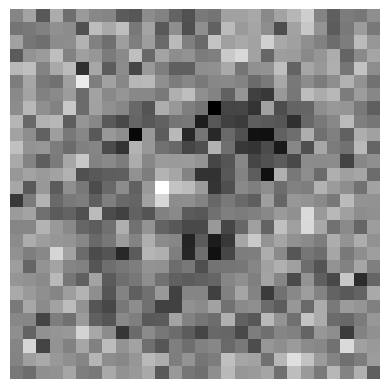

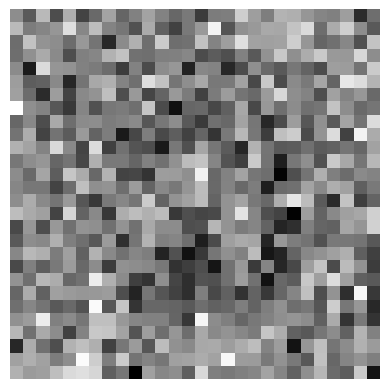

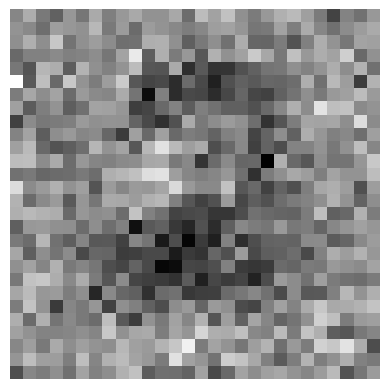

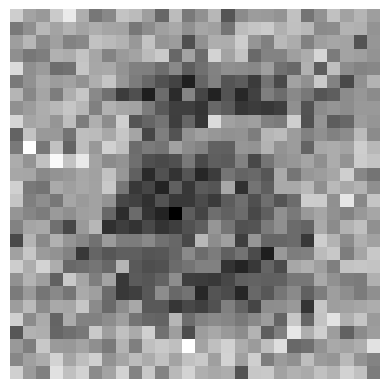

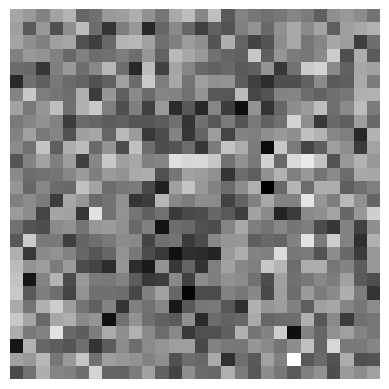

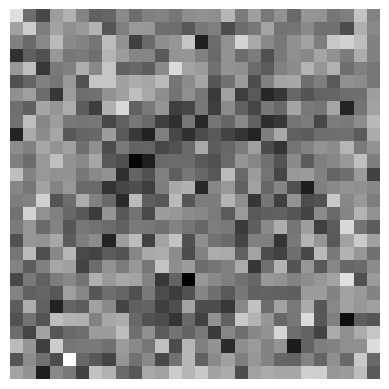

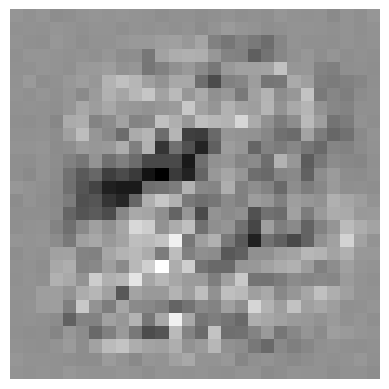

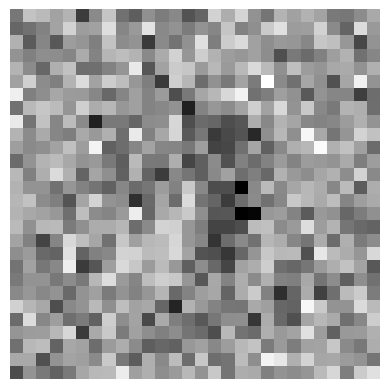

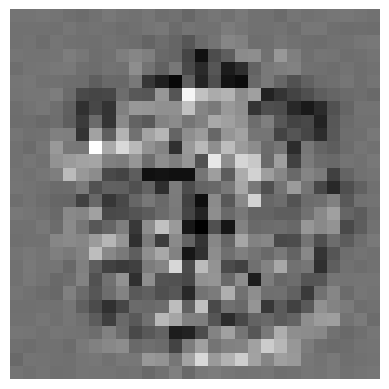

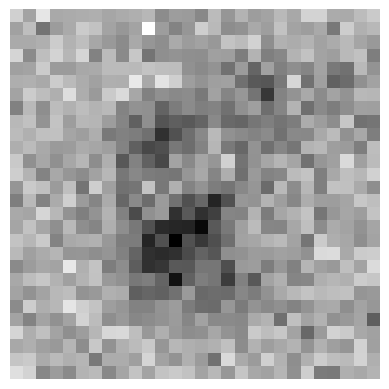

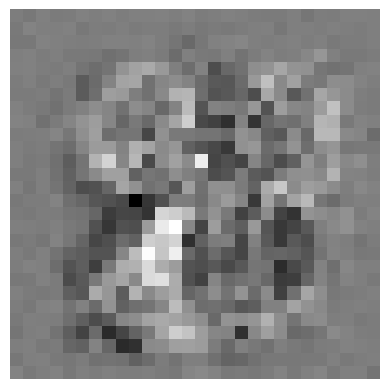

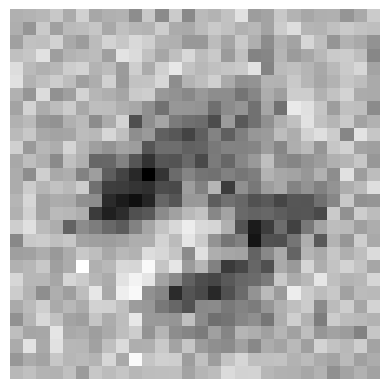

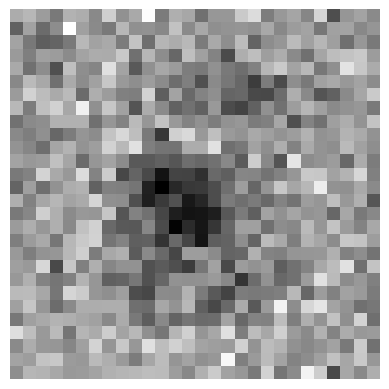

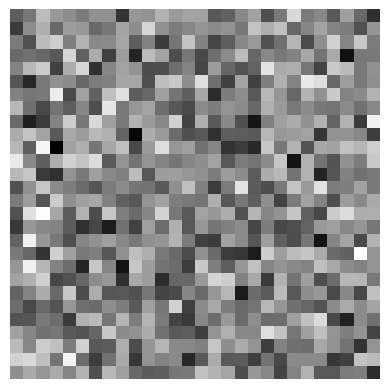

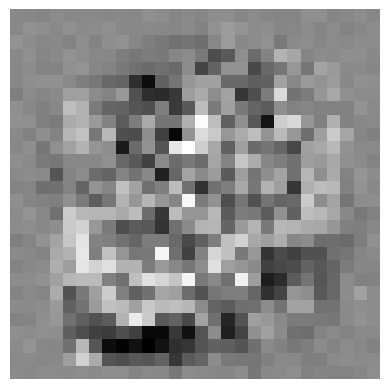

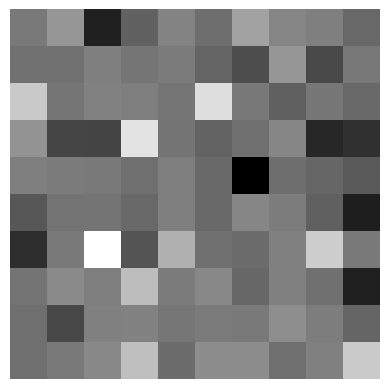

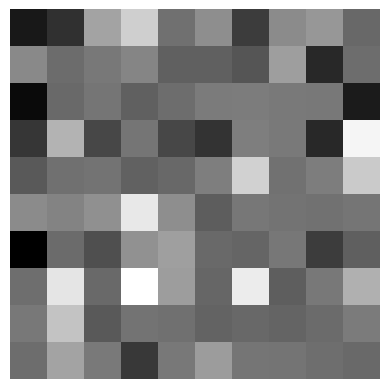

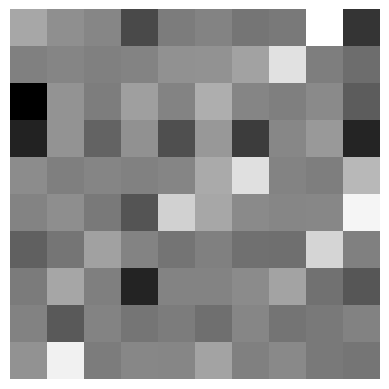

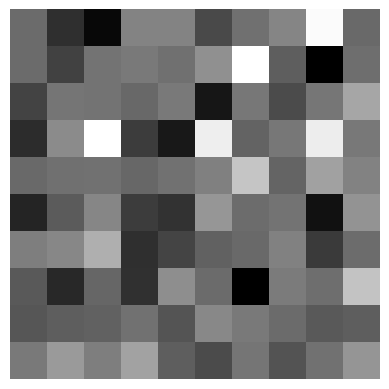

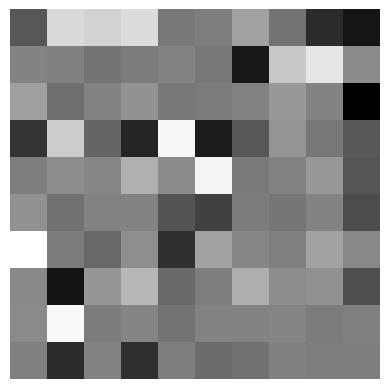

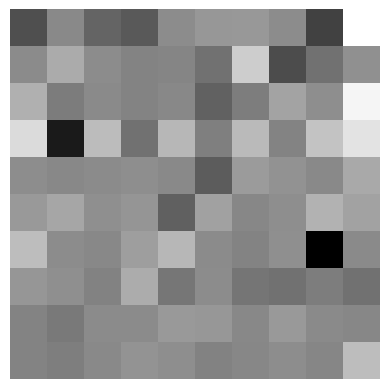

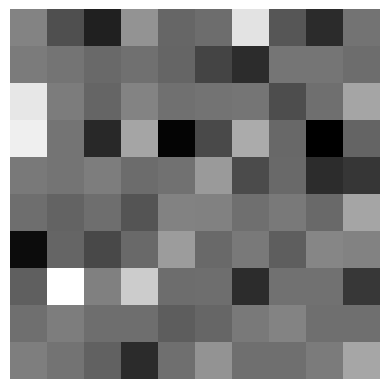

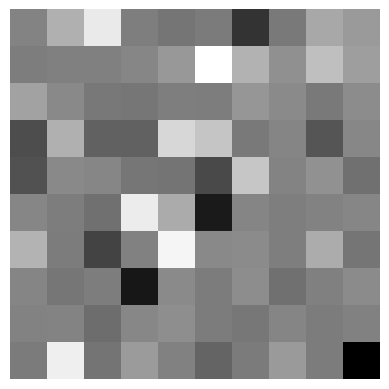

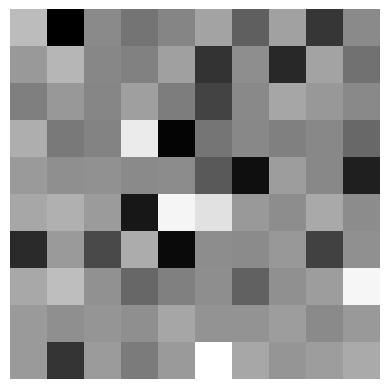

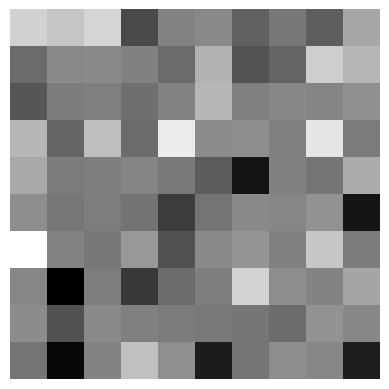

In [42]:
for layer in network.layers:
    if not isinstance(layer, Dense):
        continue

    for w in layer.weights:
        size = int(np.sqrt(w.shape[0]))
        plt.imshow(np.reshape(w, (size, size)), cmap='gray', vmin=np.min(w), vmax=np.max(w))
        plt.axis('off')  # Optional: turn off axis
        plt.show()

## Results

### Architecture:

```py
network.add(Dense(100, activation=relu, input_size=784))
network.add(Dense(10, activation=softmax))
```

### Tests

| learn_rate | epochs | batch_size | momentum | time    | results  |
|------------|--------|------------|----------|---------|----------|
| 0.01       | 50     | 100        | 0.0      | 4m 15s  | [accuracy](acc01.png), [loss](loss01.png) |
| 0.01       | 50     | 100        | 0.2      | 4m 3s   | [accuracy](acc02.png), [loss](loss02.png) |

### Architecture:

```py
network.add(Dense(100, activation=relu, input_size=784))
network.add(Dropout(0.1))
network.add(Dense(10, activation=softmax))
```

### Tests

| learn_rate | epochs | batch_size | momentum | time    | results  |
|------------|--------|------------|----------|---------|----------|
| 0.01       | 50     | 100        | 0.0      | ~4m     | [accuracy](acc03.png), [loss](loss03.png) |

In [44]:
from keras import models, layers

network = models.Sequential()
network.add(layers.Dense(100, activation="relu", input_shape=(784,)))
# network.add(layers.Dropout(0.5))
network.add(layers.Dense(10, activation="softmax"))
# network.summary()

network.compile(optimizer="sgd", loss="categorical_crossentropy", metrics=["accuracy"])

network.fit(train_X, train_Y, epochs=50, batch_size=100)

test_loss, test_acc = network.evaluate(test_X, test_Y)
print("Test Accuracy: ", test_acc, "\nTest Loss: ", test_loss)

Epoch 1/50
600/600 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.5747 - loss: 1.5247
Epoch 2/50
600/600 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8664 - loss: 0.5340
Epoch 3/50
600/600 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8864 - loss: 0.4214
Epoch 4/50
600/600 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8975 - loss: 0.3690
Epoch 5/50
600/600 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9021 - loss: 0.3480
Epoch 6/50
600/600 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9074 - loss: 0.3277
Epoch 7/50
600/600 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9112 - loss: 0.3156
Epoch 8/50
600/600 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9154 - loss: 0.3040
Epoch 9/50
600/600 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9180 - loss: 0.2892
Epoch 10/50
600/600 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9213 - loss: 0.2800
Epoch 11/50
600/600 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9247 - loss: 0.2682
Epoch 12/50
600/600 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step